# Прогнозирование вероятности дефолта для кредитных заемщиков

**Цель**: Применить методы машинного обучения для прогнозирования вероятности дефолта у кредитных заемщиков на основе их кредитной истории.

**Задачи**:
* Сделать разведывательный анализ данных
* Поработать над очисткой и обогащением данных 
* Оценить важность признаков (предикторов) для модели 
* Обучить модель логистической регрессии и спрогнозировать вероятности дефолта
* Поработать над настройкой гиперпараметров модели
* Сделать submission на Kagle

## Первый шаг: загрузка библиотек

In [1765]:
from prettytable import PrettyTable
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from pandas import Series
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, plot_confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## Описание датасета

Данные представляют из себя набор характеристик заемщиков банка: социально-демографические характеристики, данные по кредитной истории и т.д., а также бинарную целевую переменную `default` - показатель того, допустил ли заемщик дефолт по кредиту в прошлом или нет. 

Всего в датасете 110148 наблюдени, 18 потенциальный предикторов и 1 целевая переменная.

Таким образом, задача предсказания дефолта клиента сводится к задаче __логистической регрессии__.

В таблице ниже можно подробнее изучить описание всех переменных, представленные в датасете:

In [1766]:
x = PrettyTable()

x.field_names = ["Variable", "Description"]

x.add_row(["client_id", 'идентификатор клиента'])
x.add_row(["education", 'уровень образования'])
x.add_row(["sex", 'пол заемщика'])
x.add_row(["age", 'возраст заемщика'])
x.add_row(["car", 'флаг наличия автомобиля'])
x.add_row(["car_type", 'флаг автомобиля иномарки'])
x.add_row(["decline_app_cnt", 'количество отказанных прошлых заявок'])
x.add_row(["good_work", 'флаг наличия “хорошей” работы'])
x.add_row(["bki_request_cnt", 'количество запросов в БКИ'])
x.add_row(["home_address", 'категоризатор домашнего адреса'])
x.add_row(["work_address", 'категоризатор рабочего адреса'])
x.add_row(["income", 'доход'])
x.add_row(["foreign_passport", 'наличие загранпаспорта'])
x.add_row(["sna", 'связь заемщика с клиентами банка'])
x.add_row(["first_time", 'давность наличия информации о заемщике'])
x.add_row(["score_bki", 'скоринговый балл по данным из БКИ'])
x.add_row(["region_rating", 'рейтинг региона'])
x.add_row(["app_date", 'дата подачи заявки'])
x.add_row(["default", 'флаг дефолта по кредиту'])

print(x)

+------------------+----------------------------------------+
|     Variable     |              Description               |
+------------------+----------------------------------------+
|    client_id     |         идентификатор клиента          |
|    education     |          уровень образования           |
|       sex        |              пол заемщика              |
|       age        |            возраст заемщика            |
|       car        |        флаг наличия автомобиля         |
|     car_type     |        флаг автомобиля иномарки        |
| decline_app_cnt  |  количество отказанных прошлых заявок  |
|    good_work     |     флаг наличия “хорошей” работы      |
| bki_request_cnt  |       количество запросов в БКИ        |
|   home_address   |     категоризатор домашнего адреса     |
|   work_address   |     категоризатор рабочего адреса      |
|      income      |                 доход                  |
| foreign_passport |         наличие загранпаспорта         |
|       

## Загрузка данных + разметка

In [1767]:
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')
sample_submission = pd.read_csv('sample_submission_module4.csv')

Данные предоставлены двумя отдельными датасетами: __тренировочный__ и __тестовый__. Поскольку обработка и модификация признаков должна быть универсальной для всей выборки, соединими датасеты, предварительно разметив где какой. В тестовом датасете нет значений целевой переменной - их нужно будет 'по-настоящему' предсказать. 

In [1768]:
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения default, мы его должны предсказать, поэтому пока просто заполняем nan
df_test['default'] = np.nan

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # соединяем датасеты

Посмотрим что получилось:

In [1769]:
print('Размерность финального датасета:', data.shape)
data.head(5)

Размерность финального датасета: (110148, 20)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,NaN
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,NaN
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,NaN
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,NaN
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,NaN


## Предобработка данных: пропуски

In [1770]:
# сразу же удалим неинформативный признак
data.drop('client_id', axis=1, inplace=True)

__Избавляемся от пропусков__

In [1771]:
data.isna().sum()

app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
sample                  0
default             36349
dtype: int64

Видим, что пропуски есть только в переменной `education`. Напоминаю, что пропуски в переменной `default` - искусственные :) 

Посмотрим, какой процент наблюдений имеет пропущенные значения:

In [1772]:
print('Пропущенных значений в переменной education:', round(
    data['education'].isna().sum()/len(data), 4)*100, '%')

Пропущенных значений в переменной education: 0.43 %


Пропущенный значений довольно мало, но удалять их все равно не хочется! Найдем самую часто встречающуюся категорию и заменим пропущенные значения на нее.

In [1773]:
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [1774]:
data['education'] = data['education'].fillna(
    data.education.mode()[0])  # заполняем самым частым значением

## Эксплораторный анализ данных

В наших данных довольно много переменных разного типа. Для большей структурированность эксплораторного анализа формально распределим предикторы по типу данных: __количественные, бинарные, и категориальные__. 

In [1775]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

cat_cols = ['education', 'work_address', 'home_address',
            'sna', 'first_time', 'region_rating', 'app_date']

num_cols = ['income', 'decline_app_cnt', 'age', 'bki_request_cnt', 'score_bki']

## Количественные переменные

In [1776]:
# визуализация для количественных переменных - код заимствован у Natalia Melnik - очень понравилась идея визуализации

def visual(col, size=6):
    fig, (g1, g2) = plt.subplots(1, 2, figsize=(2*size, size))
    fig.suptitle('Histogram and boxplot for {0} '.format(col), fontsize=18)

    g1.hist(data[col], bins=20, histtype='bar', align='mid',
            rwidth=0.8, color='green')  # гистограмма

    # боксплот для того, чтобы посмотреть выбросы
    g2.boxplot(data[col], vert=False)
    plt.figtext(0.5, 0, col, fontsize=16)
    plt.show

In [1777]:
def outliers(col):  # подсчет количества выбросов
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outs = ((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR)))
    outs_fin = outs.sum()
    print('Количество выбросов для переменной', data[col].name, '=', outs_fin)

In [1778]:
def box_hue(col, text):  # сравнение дефолтных и недефолтных клиентов
    g = sns.boxplot(x="default", y=col, data=data, palette='rainbow').\
        set_title('Дефолтные клиенты в среднем имеют\n '+text +
                  ':')  # заголовок редактируется в зависимости от графика
    g.figure.set_size_inches(7, 5)

__Зарплата__

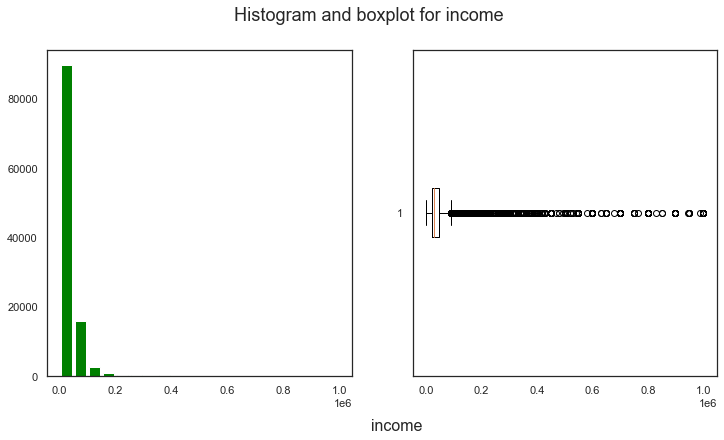

In [1779]:
visual('income')

Видим, что распределение очень смещено и имеет большой правый хвост. По графику боксплота видно, что в данных очень много выбросов. Посчитаем количество выбросов. Затем, прологорифмируем и посмотрим, получится ли сократить кол-во выбросов и улучшить распределение.

In [1780]:
outliers('income')  # очень много выбросов

Количество выбросов для переменной income = 7000


In [1781]:
data['income_log'] = np.log(data['income'] + 1)

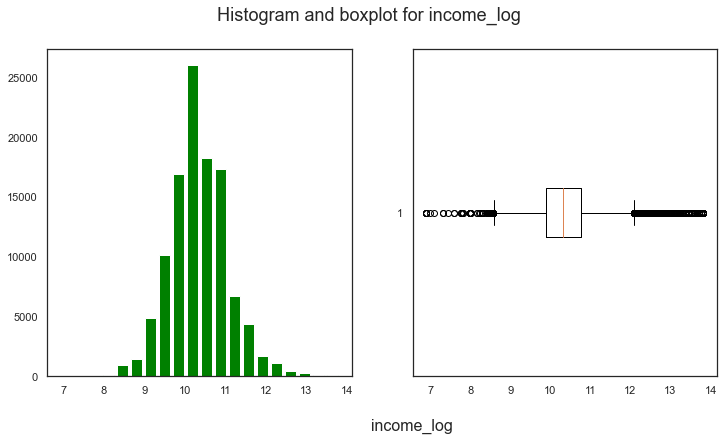

In [1782]:
visual_num('income_log')

In [1783]:
outliers('income_log')

Количество выбросов для переменной income_log = 2609


Видим, что логарифмирование помогло не только сделать распределение более нормальным, но и значительно уменьшить количество выбросов. Тем не менее, интуитивно кажется, что удалять такое количество наблюдений не стоит.

In [1784]:
data = data.drop('income', axis=1)

Посмотрим также на отличая между дефолтными и недефолтными клиентами по этой переменной:

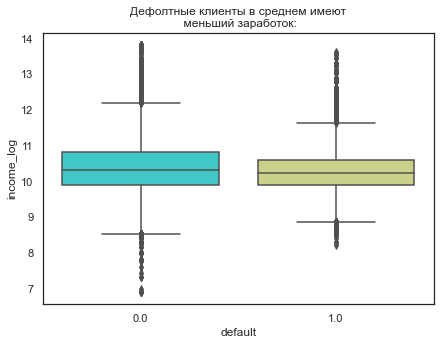

In [1785]:
box_hue('income_log', 'меньший заработок')

In [1786]:
num_cols.append('income_log')
num_cols.remove('income')

__Возраст__

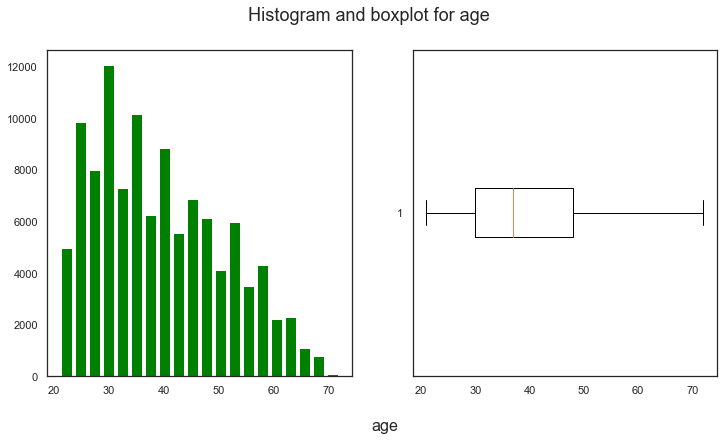

In [1787]:
visual('age')

Видим, что возраст клиентов банка распределен довольно нормально, однако нбольшой перекос все же есть. Как видим по боксплоты - выбросов не имеется. Прологорифмируем в любом случае, поскольку это поможет сделать распределение еще более нормальным.

In [1788]:
outliers('age')

Количество выбросов для переменной age = 0


In [1789]:
data['age_log'] = np.log(data['age'] + 1)

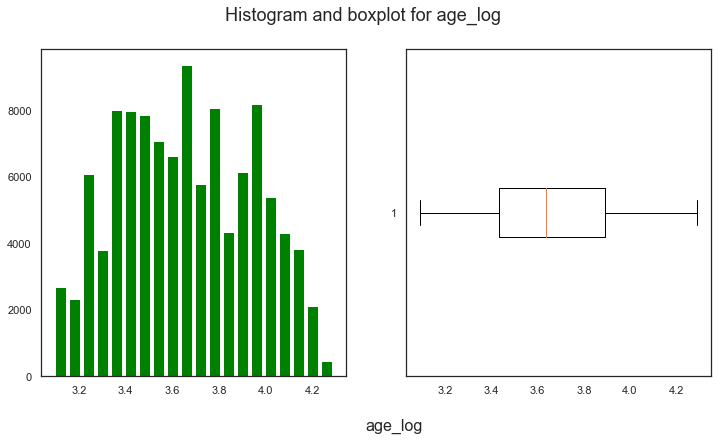

In [1790]:
visual('age_log')  # более нормальное

In [1791]:
data = data.drop('age', axis=1)

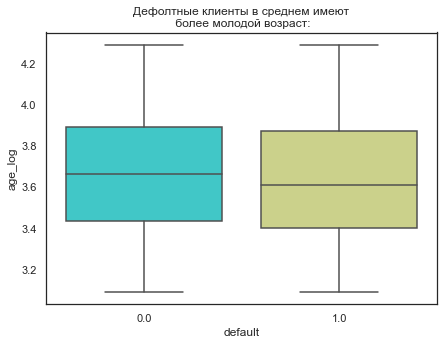

In [1792]:
box_hue('age_log', 'более молодой возраст')

In [1793]:
num_cols.append('age_log')
num_cols.remove('age')

__Количество отклоненных заявок__

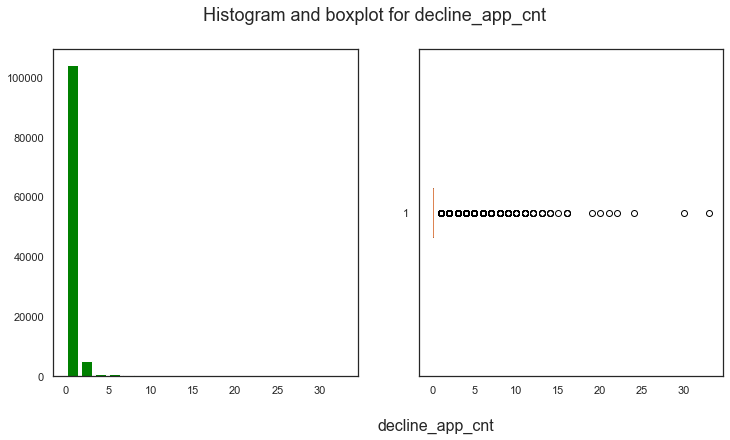

In [1794]:
visual('decline_app_cnt')

По гистограмме можно сказать, что распределение сильно смещенное. По боксплоту видно, что есть огромное количество выбросов.

In [1795]:
outliers('decline_app_cnt')  # огромное количество

Количество выбросов для переменной decline_app_cnt = 18677


Видим, что превалирующее большинство значений сосредоточено около 0. Посмотрим на конкретные значения:

In [1796]:
data['decline_app_cnt'].value_counts(normalize=True)

0     0.830437
1     0.113484
2     0.032883
3     0.012392
4     0.005502
5     0.002315
6     0.001416
7     0.000527
8     0.000336
9     0.000263
10    0.000145
11    0.000091
12    0.000045
13    0.000036
14    0.000027
16    0.000027
30    0.000009
15    0.000009
19    0.000009
20    0.000009
21    0.000009
22    0.000009
24    0.000009
33    0.000009
Name: decline_app_cnt, dtype: float64

Видим, что 96% наблюдений принадлежат категории от 0 до 2. Другими словами, в 83% случаев клиент не имеет отклоненного заявления, и еще в 11% и 3% случаев имеет 1 и 2 отказа соответственно.

Сделаем из этой переменной категориальную с категориями 0 --> 0,1-2 --> 1,больше двух --> 2. Проблема с выбросами решена сама собой.

In [1797]:
data['decline_app_cnt'] = data['decline_app_cnt'].apply(
    lambda x: 2 if x >= 3 else (1 if x > 0 else 0))

In [1798]:
cat_cols.append('decline_app_cnt')
num_cols.remove('decline_app_cnt')

__Количество запросов в БКИ__

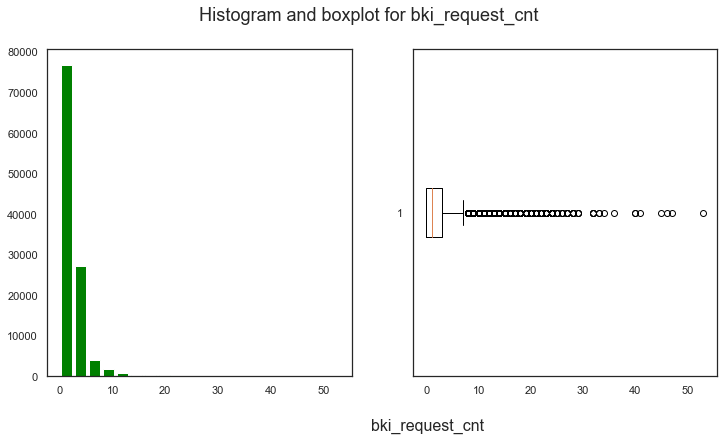

In [1799]:
visual('bki_request_cnt')

In [1800]:
outliers('bki_request_cnt')

Количество выбросов для переменной bki_request_cnt = 2636


По гистограмме видим, что количество запросов в БКИ тоже сильно смещено, где превалирующие количество запросов варьируется от 0 до 10. Также имеем достаточно много выбросов. Применим стандартную процедуру логарифмирования.

In [1801]:
data['bki_request_cnt_log'] = np.log(data['bki_request_cnt'] + 1)

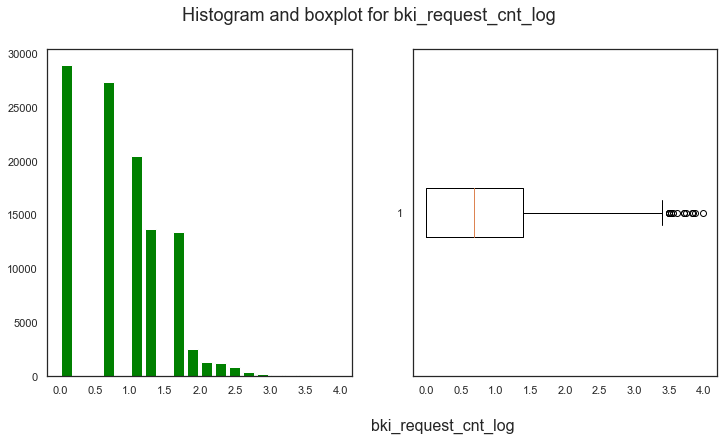

In [1802]:
visual('bki_request_cnt_log')

In [1803]:
outliers('bki_request_cnt_log')

Количество выбросов для переменной bki_request_cnt_log = 15


Распределение стало чуть более нормальным, а количество выбросов сократилось до 15! Сможем спокойно удалить их позже.

Наконец, посмотрим на разницу между дефолтными и недефолтными клиентами:

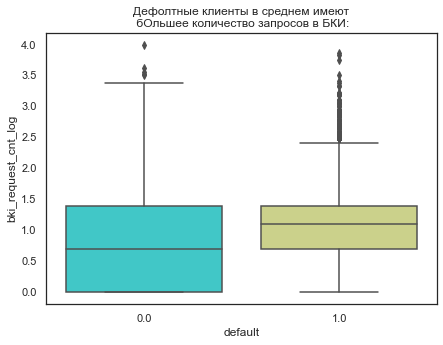

In [1804]:
box_hue('bki_request_cnt_log', 'бОльшее количество запросов в БКИ')

In [1805]:
num_cols.append('bki_request_cnt_log')
num_cols.remove('bki_request_cnt')

__Балл БКИ__

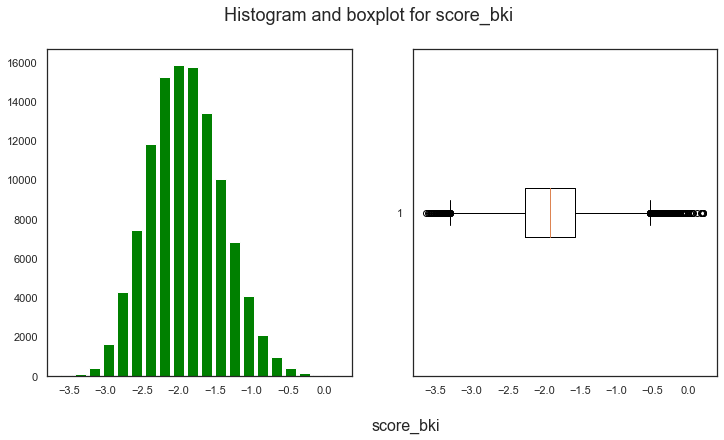

In [1806]:
visual('score_bki')

In [1807]:
outliers('score_bki')  # небольшое количество выбросов

Количество выбросов для переменной score_bki = 518


Распределение выглядит довольно нормально - логарифмировать смысла нет, однако присутствуют выбросы, которые следует удалить.

Посмотрим на разницу дефолтных и не дефолтных клиентов по скорингу БКИ:

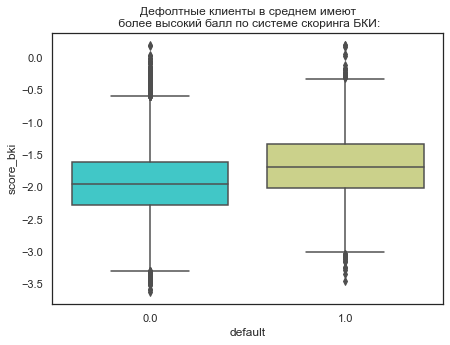

In [1808]:
box_hue('score_bki', 'более высокий балл по системе скоринга БКИ')

Можно предположить, что система скоринга БКИ не совсем интуитивно понятна, однако из данных следует, что чем меньше балл по этой системе, тем более надежным считается заемщик.

__Организованно избавимся от выбросов в непрерывных переменных там, где это необходимо:__

Поскольку я обрабатывала тренировочный и тестовый датасет вместе - удаление выбросов приводит к несовпадению количества строк у тестовых датасетов (изначального и финального тестового), что, в свою очередь, не позволяет сделать submission. В этом проекте удаление выбросов - не критично, поэтому осознанно пропустим их удаление. 

Pешение данной проблемы - обрабатывать тренировочный и тестовый датасет по отдельности, что очень времязатратно. Стоит поискать более оптимальное решение и подумать над его имплементацией. 

In [1809]:
# поиск IQR и границ выбросов
# def iqr_outs(col):
#Q1, Q3 = np.percentile(col, [25, 75])
#IQR = Q3 - Q1
#lower_bound = Q1 - (IQR * 1.5)
#upper_bound = Q3 + (IQR * 1.5)
# return lower_bound, upper_bound

In [1810]:
# inspired by Andrew Zhukov
# удаление выбросов
#сols_to_filter = ['bki_request_cnt_log', 'score_bki']
# for colname in сols_to_filter:
#d = iqr_outs(data[colname])
#data = data.loc[data[colname].between(d[0], d[1])]

__Стандартизируем непрерывные переменные:__

In [1811]:
data[num_cols] = RobustScaler().fit_transform(data[num_cols])

### Корреляционный анализ

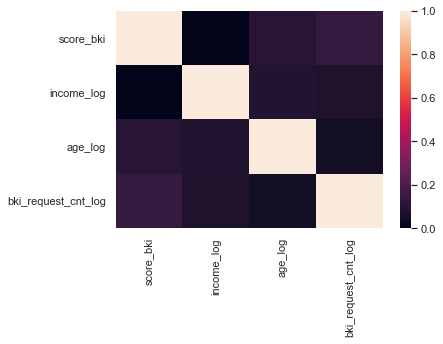

In [1812]:
gg = sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)
gg.figure.set_size_inches(6, 4)

Видим, что высоких корреляций между непрерывными предикторами не обнаруживается,и,следовательно, проблема мультиколлинеарности не возникает.

### Значимость непрерывных переменных

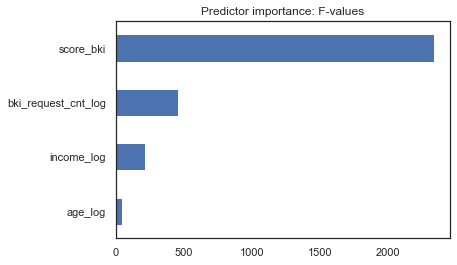

In [1813]:
# важность непрерывных признаков только на тренировочной выборке, поскольку на тестовой реальных значений целевой переменной нет
imp_num = Series(f_classif(data[data['sample'] == 1][num_cols],
                           data[data['sample'] == 1]['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', title='Predictor importance: F-values')

Основываясь на результатах ANOVA, чем выше значение F-value, тем меньше вероятность того, что средние значения наших непрерывных предикторов по двум категориям целевой переменной не отличаются, и тем важнее данный признак для нашей линейной модели. 

По графику видно, что средний балл БКИ наболее статистически значимо отличается среди дефолтных и не дефолтных клиентов, и, следовательно, этот непрерывный предиктор потенциально вносит наибольший вклад в объяснение целевой переменной.

### Бинарные переменные

In [1814]:
# определим функцию для визуализации категориальных переменных
def plot_cat(col):
    sns.set(style="white")
    plt.figure(figsize=(6, 4))
    ax = sns.histplot(data, x=col, hue="default", stat="count", multiple="fill",
                      shrink=.8, palette=sns.color_palette('pastel')[:2])
    plt.title('Распределение переменной ' +
              data[col].name.capitalize()+':', fontsize=18)
    ax.set(ylabel='Proportion')
    plt.show()

__Пол клиента__

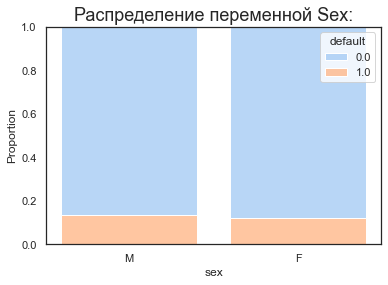

In [1815]:
plot_cat('sex')  # мужчины допускают дефолт немного чаще, чем женщины

__Наличие машины__

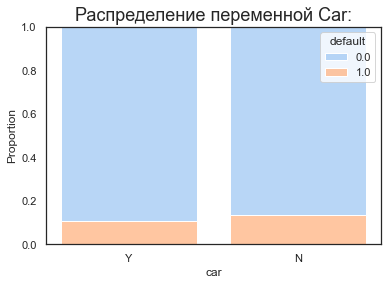

In [1816]:
plot_cat('car')  # те, у кого нет личного автомобиля, чаще допускают дефолт

__Наличие машины-иномарки__

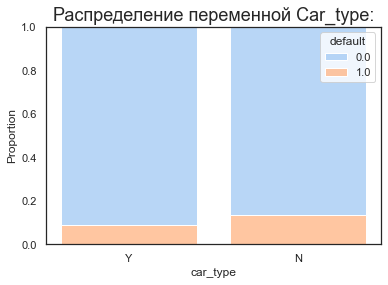

In [1817]:
# те, чья машине не является иномаркой, допускают дефолт чаще
plot_cat('car_type')

__Наличие хорошей работы__

In [1818]:
# для консистентности Yes No значений
data['good_work'] = np.where(data['good_work'] == 0, 'N', 'Y')

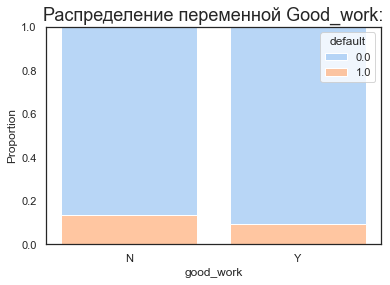

In [1819]:
plot_cat('good_work')  # те, у кого хорошая работа, реже допускают дефолт

__Наличие загранпаспорта__

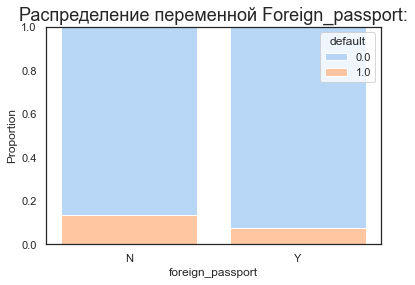

In [1820]:
# те, у кого нет загранпаспорта, почти в 2 раза чаще допускают дефолт
plot_cat('foreign_passport')

Перекодируем бинарные признаки:

In [1821]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# проверим, что все бинарные переменные теперь 1 или 0
data.head(5)

,app_date,education,sex,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,sna,first_time,foreign_passport,sample,default,income_log,age_log,bki_request_cnt_log
0,22MAR2014,GRD,1,1,1,0,0,-0.506914,3,50,1,2,1,4,0,0,NaN,0.583492,-0.516321,0.500000
1,24JAN2014,SCH,0,0,0,2,0,0.600428,2,50,1,2,4,3,0,0,NaN,-2.046507,0.112035,0.292481
2,23MAR2014,UGR,1,1,1,0,0,0.331363,1,50,1,2,1,3,1,0,NaN,0.000000,0.642678,0.000000
3,03FEB2014,SCH,1,0,0,0,0,-0.654628,1,40,1,2,1,3,0,0,NaN,-0.648770,0.885618,0.000000
4,04FEB2014,GRD,0,0,0,0,0,-0.818256,0,80,2,3,1,3,0,0,NaN,1.583512,0.056736,-0.500000


### Категориальные переменные

In [1822]:
cat_cols

['education',
 'work_address',
 'home_address',
 'sna',
 'first_time',
 'region_rating',
 'app_date',
 'decline_app_cnt']

__Образование__

Среди тех, у кого наивысший уровень образования - школа (SCH) или неоконченное высшее (UGR), чаще всего допускаются дефолты, по сравнению с пропорцией дефолтов в других категориях образования.

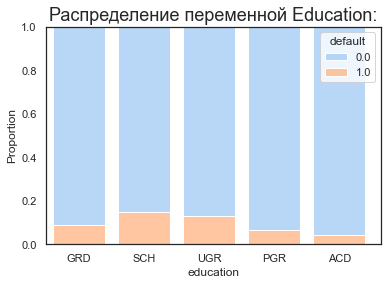

In [1823]:
plot_cat('education')

In [1824]:
# теперь поменяем на числовые
enc = LabelEncoder()
enc.fit(data['education'])
data['education'] = enc.transform(data['education'])

__Домашний и рабочий адрес__

In [1825]:
# чтобы не было проблем с визуализацией
data['home_address'] = np.where(
    data['home_address'] == 1, '1', np.where(data['home_address'] == 2, '2', '3'))
data['work_address'] = np.where(
    data['work_address'] == 1, '1', np.where(data['work_address'] == 2, '2', '3'))

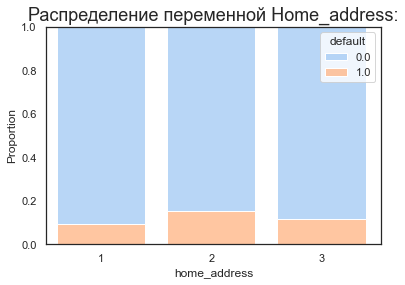

In [1826]:
# чаще дефолты допускаются у тех, чей домашний адрес категоризирован как 2
plot_cat('home_address')

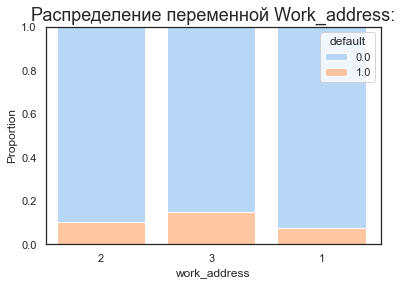

In [1827]:
# чаще дефолты допускаются у тех, чей рабочий адрес категоризирован как 3
plot_cat('work_address')

__Связь заемщика с клиентами банка__

In [1828]:
# чтобы не было проблем с визуализацией
data['sna'] = np.where(data['sna'] == 1, '1', np.where(
    data['sna'] == 2, '2', np.where(data['sna'] == 3, '3', 4)))

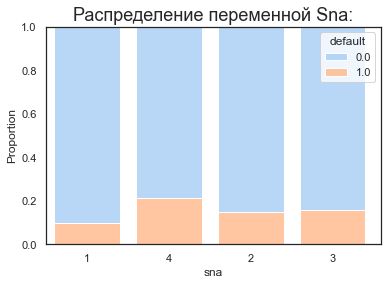

In [1829]:
# чаще дефолты допускаются, если связь заемщика с клиентами банка оценивается на 4 из диапазона 1-4
plot_cat('sna')

__Давность наличия информации о заемщике__

In [1830]:
# чтобы не было проблем с визуализацией
data['first_time'] = np.where(data['first_time'] == 1, '1', np.where(
    data['first_time'] == 2, '2', np.where(data['first_time'] == 3, '3', 4)))

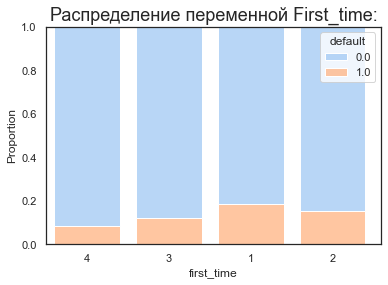

In [1831]:
# можно предположить, новые заемщики (1 из 4 по давности) допускают дефолты чаще
plot_cat('first_time')

__Рейтинг региона__

In [1832]:
data['region_rating'] = np.where(data['region_rating'] == 20, '20',
                                 np.where(data['region_rating'] == 30, '30',
                                          np.where(data['region_rating'] == 40, '40',
                                                   np.where(data['region_rating'] == 50, '50',
                                                            np.where(data['region_rating'] == 60, '60',
                                                                     np.where(data['region_rating'] == 70, '70', '80'))))))

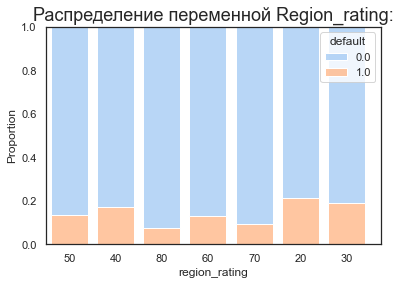

In [1833]:
plot_cat('region_rating')
# можно предположить, что более плохим районам давали меньший рейтинг, и, поэтому, там чаще допускаются дефолты

__Количество отклоненных заявок__

In [1834]:
data['decline_app_cnt'] = np.where(data['decline_app_cnt'] == 0, '0', np.where(
    data['decline_app_cnt'] == 1, '1', '2'))

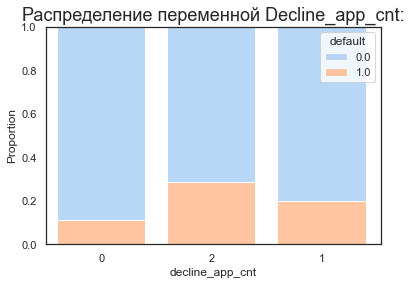

In [1835]:
# у заемщиков, которым отказывали в кредите больше 2 раз, наиболее часто случается дефолт
plot_cat('decline_app_cnt')

### Поработаем с признаком `дата заявки на кредит` (`app_date`)

In [1836]:
from datetime import datetime
data['app_date'] = pd.to_datetime(
    data['app_date'], format='%d%b%Y')  # преобразуем в дату

Посчитаем пропорцию заявок по месяцам.

Есть данные по 4 месяцам: январь, февраль, март и апрель (1-4). Заявок примерно одинаково в каждый месяц, но в марте чуть больше.

In [1837]:
data['app_date'].dt.month.value_counts(normalize=True)

3    0.286859
2    0.246005
4    0.238461
1    0.228674
Name: app_date, dtype: float64

Добавим новый признак - месяц:

In [1838]:
data['app_month'] = data['app_date'].dt.month

In [1839]:
data['app_month'] = np.where(data['app_month'] == 1, '1', np.where(data['app_month'] == 2,
                                                                   '2', np.where(data['app_month'] == 3, '3', '4')))

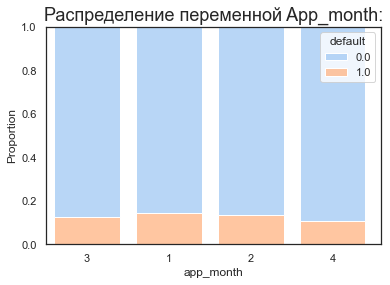

In [1840]:
# дефолтов везде примерно одинаково, однако для заявивших на кредит в январе дефолтов допущено чуть больше
plot_cat('app_month')

In [1841]:
data = data.drop('app_date', axis=1)

In [1842]:
cat_cols.append('app_month')
cat_cols.remove('app_date')

### Значимость категориальных (и бинарных) признаков

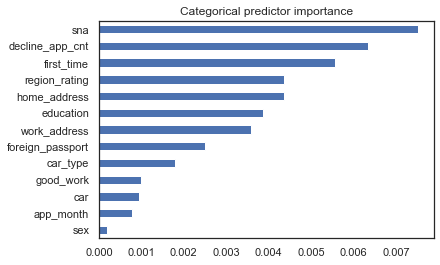

In [1843]:
imp_cat = Series(mutual_info_classif(data[data['sample'] == 1][bin_cols + cat_cols], data[data['sample'] == 1]['default'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Categorical predictor importance')

По графику видно, что из категориальных переменных нибольший вклад в модель вносят переменные `связь заемщика с клиентами банка` и `количество отклоненных заявок`.

Перекодируем все категориальные переменные в dummy:

In [1844]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

__Проверим, что все типы переменных модифицировались нормально:__

In [1845]:
data[num_cols].head(4)  # все непрерывные перемнные в порядке

,score_bki,income_log,age_log,bki_request_cnt_log
0,-0.506914,0.583492,-0.516321,0.500000
1,0.600428,-2.046507,0.112035,0.292481
2,0.331363,0.000000,0.642678,0.000000
3,-0.654628,-0.648770,0.885618,0.000000


In [1846]:
data[bin_cols].head(4)  # все бинарные перемнные в порядке

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,1,0,1
3,1,0,0,0,0


In [1847]:
df1 = data.drop(num_cols, axis=1)
df = df1.drop(bin_cols, axis=1)
df.head(4)  # все бинарные перемнные в порядке

,bki_request_cnt,sample,default,education_0,education_1,education_2,education_3,education_4,work_address_1,work_address_2,...,region_rating_60,region_rating_70,region_rating_80,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,app_month_1,app_month_2,app_month_3,app_month_4
0,3,0,NaN,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,2,0,NaN,0,0,0,1,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2,1,0,NaN,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
3,1,0,NaN,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0


### Работа с целевой переменной

Посмотрим как распределяются знаения целевой переменной:

In [1848]:
data['default'].value_counts(normalize=True)  # 87% - не дефолт, 13% - дефолт

0.0    0.873006
1.0    0.126994
Name: default, dtype: float64

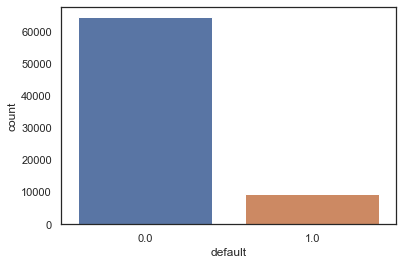

In [1849]:
sns.countplot(x='default', data=data)

Видим, что целевая переменная распределена очень неравномерно. Позже применим метод random oversampling, чтобы справиться с этой проблемой.

## Обучение модели логистической регрессии

In [1850]:
# Таблица метрик для сравнения результатов каждой модели -- заимствовано у Melnik Natalia
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC']
summary = pd.DataFrame(index=metrics)


def summary_metrics(summary, col, y_valid, y_pred, y_probs):
    values = [accuracy_score(y_valid, y_pred), precision_score(y_valid, y_pred), recall_score(y_valid, y_pred),
              f1_score(y_valid, y_pred), roc_auc_score(y_valid, y_probs)]
    summary[col] = values
    return summary

In [1851]:
# разделим снова на train и test, т.к. все признаки уже обработаны
train_data = data[data['sample'] == 1].drop(['sample'], axis=1)
test_data = data[data['sample'] == 0].drop(['sample'], axis=1)

In [1852]:
# выделим целевую переменную и признаки
X = train_data.drop(['default'], axis=1).values
y = train_data['default'].values

In [1853]:
# сбалансируем классы в целевой переменной методом undersampling
under_sampler = RandomUnderSampler(random_state=42)
X, y = under_sampler.fit_resample(X, y)

In [1854]:
# разделим на тренировочные и валидационные выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

In [1855]:
my_model = LogisticRegression(random_state=42, max_iter=1000)
my_model.fit(X_train, y_train)  # обучаем модель

LogisticRegression(max_iter=1000, random_state=42)

In [1856]:
# предсказываем вероятности для ROC AUC
probs = my_model.predict_proba(X_valid)
y_probs = probs[:, 1]

y_pred = my_model.predict(X_valid)  # предсказываем сами значения

In [1857]:
# посмотрим метрики базовой модели
summary_metrics(summary, 'model1', y_valid, y_pred, y_probs)

,model1
accuracy,0.664829
precision,0.664654
recall,0.665363
f1_score,0.665008
ROC_AUC,0.729663


Метрики довольно неплохие, применение undersampling решило проблему очень низкого recall и f1 score (неспособность модели хорошо находить позитивный класс - в нашем случае: определять дефолтных клиентов), которые возникали при несбалансированной выборке. 

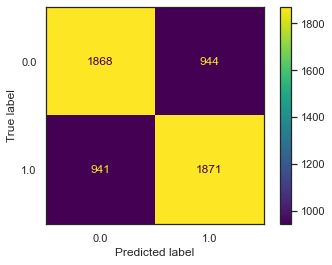

In [1858]:
plot_confusion_matrix(my_model, X_valid, y_valid)

Видим, что модель достаточно хорошо определяет как дефолтных, так и не дефолтных клиентов, что очень важно в рамках нашей задачи.

### Поиск оптимальных гиперпараметров

In [1859]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 59.94842503189409


In [1860]:
# обучаем модель с подобранными параметрами
model_best_params = LogisticRegression(
    penalty='l2', C=7.742636826811269, max_iter=1000)
model_best_params.fit(X_train, y_train)

LogisticRegression(C=7.742636826811269, max_iter=1000)

In [1861]:
probs = model_best_params.predict_proba(X_valid)
y_probs = probs[:, 1]
y_pred = model_best_params.predict(X_valid)

In [1862]:
# сравним метрики с предыдущей моделью
# метрики практически не изменились
summary_metrics(summary, 'model2', y_valid, y_pred, y_probs)

,model1,model2
accuracy,0.664829,0.664651
precision,0.664654,0.664418
recall,0.665363,0.665363
f1_score,0.665008,0.664890
ROC_AUC,0.729663,0.729611


__Более сложный поиск гиперпараметров:__

In [1863]:
model = LogisticRegression(random_state=42)
param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
# печатаем параметры
best_parameters = model.get_params()

In [1864]:
# оптимальные параметры
for param_name in best_parameters.keys():
    print(f'  {param_name} = {best_parameters[param_name]},')

  C = 1.0,
  class_weight = none,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 100,
  multi_class = auto,
  n_jobs = None,
  penalty = none,
  random_state = 42,
  solver = sag,
  tol = 0.0001,
  verbose = 0,
  warm_start = False,


In [1865]:
# обучаем модель с оптимальными гиперпараметрами
model_best_params = LogisticRegression(C=1.0,
                                       class_weight=None,
                                       dual=False,
                                       fit_intercept=True,
                                       intercept_scaling=1,
                                       l1_ratio=None,
                                       max_iter=100,
                                       multi_class='auto',
                                       n_jobs=None,
                                       penalty='none',
                                       random_state=42,
                                       solver='lbfgs',
                                       tol=0.0001,
                                       verbose=0,
                                       warm_start=False)

model_best_params.fit(X_train, y_train)

LogisticRegression(penalty='none', random_state=42)

In [1866]:
probs = model_best_params.predict_proba(X_valid)
y_probs = probs[:, 1]
y_pred = model_best_params.predict(X_valid)

# сравним метрики с предыдущими моделью
# метрики практически не изменились
summary_metrics(summary, 'model3', y_valid, y_pred, y_probs)

,model1,model2,model3
accuracy,0.664829,0.664651,0.665185
precision,0.664654,0.664418,0.664892
recall,0.665363,0.665363,0.666074
f1_score,0.665008,0.664890,0.665482
ROC_AUC,0.729663,0.729611,0.729619


__Подкрутим метрики вручную:__

In [1867]:
# обучаем модель с оптимальными гиперпараметрами (интуитивно подкручиваем параметры)
model_best_params = LogisticRegression(C=1.0,
                                       class_weight='balanced',
                                       dual=False,
                                       fit_intercept=True,
                                       intercept_scaling=1,
                                       l1_ratio=None,
                                       max_iter=100,
                                       multi_class='auto',
                                       n_jobs=None,
                                       penalty='l2',
                                       random_state=42,
                                       solver='liblinear',
                                       tol=0.001,
                                       verbose=0,
                                       warm_start=False)

model_best_params.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear',
                   tol=0.001)

In [1868]:
probs = model_best_params.predict_proba(X_valid)
y_probs = probs[:, 1]
y_pred = model_best_params.predict(X_valid)

# сравним метрики с предыдущими моделью
summary_metrics(summary, 'model4', y_valid, y_pred, y_probs)

,model1,model2,model3,model4
accuracy,0.664829,0.664651,0.665185,0.664651
precision,0.664654,0.664418,0.664892,0.664534
recall,0.665363,0.665363,0.666074,0.665007
f1_score,0.665008,0.664890,0.665482,0.664771
ROC_AUC,0.729663,0.729611,0.729619,0.729664


Итак, видим, что метрики практически не изменились, однако последняя модель имеет наибольший ROC AUC. Будем использовать ее для submission.

## Submission

In [1869]:
X_test = test_data.drop(['default'], axis=1)
y_pred_prob = model_best_params.predict_proba(X_test)[:, 1]
submit = pd.DataFrame(df_test.client_id)
submit['default'] = y_pred_prob
submit.to_csv('submission_my.csv', index=False)
submit

,client_id,default
0,74835,0.206657
1,17527,0.735368
2,75683,0.311853
3,26883,0.375473
4,28862,0.146161
...,...,...
36344,83775,0.800971
36345,106254,0.109968
36346,81852,0.785290
36347,1971,0.617451
